In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import RFE,VarianceThreshold,SelectKBest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
import seaborn as sns

In [2]:
X_train = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv")

In [3]:
X_train

,time_stamp,contentid,user_action,sellingprice,product_name,brand_id,brand_name,businessunit,product_gender,category_id,Level1_Category_Id,Level1_Category_Name,Level2_Category_Id,Level2_Category_Name,Level3_Category_Id,Level3_Category_Name,gender,unique_id,type
0,2020-12-02T22:26:14.023Z,39918893.0,favorite,3099.00,PerfectCare 600 EW6F449ST A+++ 9 KG 1400 Devir...,8511.0,Electrolux,Beyaz Eşya,Unisex,1272.0,1071.0,Elektronik,1212.0,Beyaz Eşya,1272.0,Çamaşır Makinesi,F,425,train
1,2020-12-08T23:15:04.603Z,3558544.0,favorite,3079.00,WW90J5475FW A+++ 1400 Devir 9 kg Çamaşır Makinesi,3228.0,Samsung,Beyaz Eşya,NaN,1272.0,1071.0,Elektronik,1212.0,Beyaz Eşya,1272.0,Çamaşır Makinesi,F,425,train
2,2020-12-05T16:19:01.157Z,31292729.0,favorite,3999.00,KM 9711 A++ 9 kg Çamaşır Kurutma Makinesi,10989.0,Vestel,Beyaz Eşya,Unisex,1276.0,1071.0,Elektronik,1212.0,Beyaz Eşya,1276.0,Kurutma Makinesi,F,425,train
3,2020-12-05T16:28:00Z,6363103.0,visit,2544.00,CMI 9710 A+++ 1000 Devir 9 kg Çamaşır Makinesi,10989.0,Vestel,Beyaz Eşya,NaN,1272.0,1071.0,Elektronik,1212.0,Beyaz Eşya,1272.0,Çamaşır Makinesi,F,425,train
4,2020-12-02T22:26:59Z,39918893.0,visit,3099.00,PerfectCare 600 EW6F449ST A+++ 9 KG 1400 Devir...,8511.0,Electrolux,Beyaz Eşya,Unisex,1272.0,1071.0,Elektronik,1212.0,Beyaz Eşya,1272.0,Çamaşır Makinesi,F,425,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5493263,2020-12-09T11:41:59Z,31440796.0,search,89.50,Turbo Profesyonel Saç Kurutma Makinesi,30457.0,Powertec,Kişisel Bakım Aletleri,Unisex,864.0,1071.0,Elektronik,2373.0,Kişisel Bakım Aletleri,864.0,Saç Kurutma Makinesi,M,7062,train
5493264,2020-12-09T00:10:16Z,54677237.0,search,99.99,Erkek Gri Kot Pantolon,978383.0,ukdwear,Erkek B,Erkek,1186.0,522.0,Giyim,2869.0,Alt Giyim,1186.0,Jeans,M,7062,train
5493265,2020-12-09T11:40:57Z,2699559.0,search,169.00,Hd 6480 2200 Watt Difüzör Başlıklı İyonik Saç ...,8171.0,Grundig,Kişisel Bakım Aletleri,Unisex,864.0,1071.0,Elektronik,2373.0,Kişisel Bakım Aletleri,864.0,Saç Kurutma Makinesi,M,7062,train
5493266,2020-12-09T00:08:49.379Z,34981546.0,favorite,248.48,Siyah Siyah Erkek Sneaker,93397.0,Riccon,Branded Shoes B,Erkek,975.0,403.0,Ayakkabı,420.0,Spor Ayakkabı,975.0,Sneaker,M,7062,train


### FEATURE ENGINEERING

In [217]:
selling_price = X_train.groupby("unique_id").mean()["sellingprice"]
basket=X_train.loc[X_train["user_action"]=="basket"].groupby(["unique_id"]).count()["time_stamp"]
favorite=X_train.loc[X_train["user_action"]=="favorite"].groupby(["unique_id"]).count()["time_stamp"]
order=X_train.loc[X_train["user_action"]=="order"].groupby(["unique_id"]).count()["time_stamp"]
search=X_train.loc[X_train["user_action"]=="search"].groupby(["unique_id"]).count()["time_stamp"]
visit=X_train.loc[X_train["user_action"]=="visit"].groupby(["unique_id"]).count()["time_stamp"]
level1 = X_train.groupby(['unique_id','Level1_Category_Name']).size().reset_index(name='Count').sort_values(['unique_id','Count'],ascending=[1,0]).groupby('unique_id').head(1)
level2 = X_train.groupby(['unique_id','Level2_Category_Name']).size().reset_index(name='Count').sort_values(['unique_id','Count'],ascending=[1,0]).groupby('unique_id').head(1)
level3 = X_train.groupby(['unique_id','Level3_Category_Name']).size().reset_index(name='Count').sort_values(['unique_id','Count'],ascending=[1,0]).groupby('unique_id').head(1)
product_gender = X_train.groupby(['unique_id','product_gender']).size().reset_index(name='Count').sort_values(['unique_id','Count'],ascending=[1,0]).groupby('unique_id').head(1)
y = X_train.groupby(['unique_id','gender']).size().reset_index(name='Count').sort_values(['unique_id','Count'],ascending=[1,0]).groupby('unique_id').head(1)

In [218]:
product_gender = product_gender.drop(["Count"],axis=1).reset_index().drop(["index"],axis=1)
level3 = level3.drop(["Count"],axis=1).reset_index().drop(["index"],axis=1)
level2 = level2.drop(["Count"],axis=1).reset_index().drop(["index"],axis=1)
level1 = level1.drop(["Count"],axis=1).reset_index().drop(["index"],axis=1)

In [224]:
dataframe = pd.DataFrame(selling_price).reset_index()
dataframe2 = pd.DataFrame(basket).reset_index()
dataframe3 = pd.DataFrame(favorite).reset_index()
dataframe4 = pd.DataFrame(order).reset_index()
dataframe5 = pd.DataFrame(search).reset_index()
dataframe6 = pd.DataFrame(visit).reset_index()

In [229]:
dataframe6 = dataframe6.rename(columns = {'time_stamp':'visit'})

In [282]:
X_train_new = X_train_new.merge(product_gender,how="left")

In [243]:
X_train_new = dataframe.fillna(0)

In [244]:
print(X_train_new.columns)
print(X_train_new.shape)

Index(['unique_id', 'sellingprice', 'basket', 'favorite', 'order', 'search',
       'visit', 'gender', 'Count', 'product_gender', 'Level3_Category_Name',
       'Level2_Category_Name', 'Level1_Category_Name'],
      dtype='object')
(5618, 13)


In [245]:
X_train_new.isnull().sum()

unique_id               0
sellingprice            0
basket                  0
favorite                0
order                   0
search                  0
visit                   0
gender                  0
Count                   0
product_gender          0
Level3_Category_Name    0
Level2_Category_Name    0
Level1_Category_Name    0
dtype: int64

In [15]:
df_train, X_tr = train_test_split(X_train, test_size=0.00728164000008738, stratify=X_train[["gender", "user_action"]])

In [246]:
selling_price_test = X_test.groupby("unique_id").mean()["sellingprice"]
basket_test=X_test.loc[X_test["user_action"]=="basket"].groupby(["unique_id"]).count()["time_stamp"]
favorite_test=X_test.loc[X_test["user_action"]=="favorite"].groupby(["unique_id"]).count()["time_stamp"]
order_test=X_test.loc[X_test["user_action"]=="order"].groupby(["unique_id"]).count()["time_stamp"]
search_test=X_test.loc[X_test["user_action"]=="search"].groupby(["unique_id"]).count()["time_stamp"]
visit_test=X_test.loc[X_test["user_action"]=="visit"].groupby(["unique_id"]).count()["time_stamp"]
level1_test = X_test.groupby(['unique_id','Level1_Category_Name']).size().reset_index(name='Count').sort_values(['unique_id','Count'],ascending=[1,0]).groupby('unique_id').head(1)
level2_test = X_test.groupby(['unique_id','Level2_Category_Name']).size().reset_index(name='Count').sort_values(['unique_id','Count'],ascending=[1,0]).groupby('unique_id').head(1)
level3_test = X_test.groupby(['unique_id','Level3_Category_Name']).size().reset_index(name='Count').sort_values(['unique_id','Count'],ascending=[1,0]).groupby('unique_id').head(1)
product_gender_test = X_test.groupby(['unique_id','product_gender']).size().reset_index(name='Count').sort_values(['unique_id','Count'],ascending=[1,0]).groupby('unique_id').head(1)
y_test = X_test.groupby(['unique_id','gender']).size().reset_index(name='Count').sort_values(['unique_id','Count'],ascending=[1,0]).groupby('unique_id').head(1)

In [247]:
product_gender_test = product_gender_test.drop(["Count"],axis=1).reset_index().drop(["index"],axis=1)
level3_test = level3_test.drop(["Count"],axis=1).reset_index().drop(["index"],axis=1)
level2_test = level2_test.drop(["Count"],axis=1).reset_index().drop(["index"],axis=1)
level1_test = level1_test.drop(["Count"],axis=1).reset_index().drop(["index"],axis=1)
y_test = y_test.drop(["Count"],axis=1).reset_index().drop(["index"],axis=1)

In [248]:
dataframe_test = pd.DataFrame(selling_price_test).reset_index()
dataframe2_test = pd.DataFrame(basket_test).reset_index()
dataframe3_test = pd.DataFrame(favorite_test).reset_index()
dataframe4_test = pd.DataFrame(order_test).reset_index()
dataframe5_test = pd.DataFrame(search_test).reset_index()
dataframe6_test = pd.DataFrame(visit_test).reset_index()

In [253]:
dataframe6_test = dataframe6_test.rename(columns = {'time_stamp':'visit'})

In [255]:
dataframe_test = dataframe_test.drop_duplicates("unique_id")

In [277]:
dataframe_test = dataframe_test.merge(product_gender_test,how="left")

In [276]:
dataframe_test.drop(["product_gender"],axis=1,inplace=True)

In [270]:
dataframe_test.drop(["gender"],axis=1,inplace=True)

In [279]:
dataframe_test

,unique_id,sellingprice,basket,favorite,order,search,visit,Level3_Category_Name,Level2_Category_Name,Level1_Category_Name,product_gender
0,9,225.640314,122.0,92.0,22.0,1674.0,1392.0,Kaban & Mont,Dış Giyim,Giyim,Kadın
1,18,110.093421,2611.0,2996.0,1141.0,20321.0,44261.0,Kazak & Hırka,Üst Giyim,Giyim,Kadın
2,21,302.462468,100.0,1088.0,32.0,2744.0,4700.0,Bot & Bootie,Bot & Çizme,Giyim,Kadın
3,25,229.201033,180.0,948.0,72.0,4068.0,7812.0,Elbise,Elbise,Giyim,Kadın
4,31,227.430711,2817.0,2043.0,171.0,20583.0,48672.0,Sofra,Sofra & Mutfak,Giyim,Kadın
...,...,...,...,...,...,...,...,...,...,...,...
2375,7982,89.950000,0.0,0.0,0.0,1.0,0.0,Sweatshirt,Üst Giyim,Giyim,Kadın
2376,7990,729.000000,0.0,0.0,0.0,0.0,1.0,Koşu & Antrenman Ayakkabısı,Spor Ayakkabı,Ayakkabı,Erkek
2377,7993,0.000000,0.0,0.0,0.0,0.0,1.0,Sırt Çantası,Çanta,Aksesuar,Unisex
2378,7994,49.950000,0.0,0.0,1.0,0.0,0.0,Webcam,Bilgisayar Tablet,Elektronik,Unisex


In [278]:
dataframe_test = dataframe_test.fillna("Unisex")

In [183]:
X_test_new = dataframe_test.drop(["gender"],axis=1)

In [184]:
print(X_test_new.columns)
print(X_test_new.shape)

Index(['unique_id', 'sellingprice', 'basket', 'favorite', 'order', 'search',
       'visit', 'Level3_Category_Name', 'Level2_Category_Name',
       'Level1_Category_Name', 'product_gender'],
      dtype='object')
(2380, 11)


In [284]:
X_train_new = X_train_new.fillna("Unisex")

In [186]:
X_test_new

,unique_id,sellingprice,basket,favorite,order,search,visit,Level3_Category_Name,Level2_Category_Name,Level1_Category_Name,product_gender
0,9,225.640314,122.0,92.0,22.0,1674.0,1392.0,Kaban & Mont,Dış Giyim,Giyim,Kadın
1,18,110.093421,2611.0,2996.0,1141.0,20321.0,44261.0,Kazak & Hırka,Üst Giyim,Giyim,Kadın
2,21,302.462468,100.0,1088.0,32.0,2744.0,4700.0,Bot & Bootie,Bot & Çizme,Giyim,Kadın
3,25,229.201033,180.0,948.0,72.0,4068.0,7812.0,Elbise,Elbise,Giyim,Kadın
4,31,227.430711,2817.0,2043.0,171.0,20583.0,48672.0,Sofra,Sofra & Mutfak,Giyim,Kadın
...,...,...,...,...,...,...,...,...,...,...,...
2375,7982,89.950000,0.0,0.0,0.0,1.0,0.0,Sweatshirt,Üst Giyim,Giyim,Kadın
2376,7990,729.000000,0.0,0.0,0.0,0.0,1.0,Koşu & Antrenman Ayakkabısı,Spor Ayakkabı,Ayakkabı,Erkek
2377,7993,0.000000,0.0,0.0,0.0,0.0,1.0,Sırt Çantası,Çanta,Aksesuar,Unisex
2378,7994,49.950000,0.0,0.0,1.0,0.0,0.0,Webcam,Bilgisayar Tablet,Elektronik,Unisex


In [189]:
X_train_new.to_excel("X_train_IE582.xlsx")

In [190]:
X_test_new.to_excel("X_test_IE582.xlsx")

In [285]:
X_train_last = pd.read_excel("X_train_IE582.xlsx")
X_test_last = pd.read_excel("X_test_IE582.xlsx")

In [287]:
X_train_last = X_train_last.loc[:, ~X_train_last.columns.str.contains('^Unnamed')]
X_test_last = X_test_last.loc[:, ~X_test_last.columns.str.contains('^Unnamed')]

In [288]:
X_train_last = X_train_last.set_index("unique_id")

In [289]:
X_test_last = X_test_last.set_index("unique_id")

In [290]:
X_train_last

,sellingprice,basket,favorite,order,search,visit,Level1_Category_Name,Level2_Category_Name,Level3_Category_Name,product_gender,gender
unique_id,,,,,,,,,,,
1,166.306861,218,184,6,1342,1490,Ev & Mobilya,Ev Tekstili,Halı & Kilim & Paspas,Unisex,F
2,154.142955,52,1784,4,1834,1562,Giyim,Sofra & Mutfak,Yatak Odası Tekstili,Kadın,F
3,271.316497,128,0,44,864,540,Giyim,Elbise,Elbise,Kadın,F
4,289.891374,1800,780,336,12756,17268,Giyim,Üst Giyim,Kazak & Hırka,Kadın,F
5,137.397251,1025,5,50,2990,16505,Kozmetik & Kişisel Bakım,Makyaj,Dudak Makyajı,Kadın,F
...,...,...,...,...,...,...,...,...,...,...,...
7991,925.000000,0,0,1,0,0,Yaşam,Bahçe ve Yapı Market,Bahçe,Unisex,F
7992,87.000000,0,0,0,0,1,Yaşam,Kitap,Eğitim,Unisex,F
7995,4699.000000,0,0,0,0,1,Elektronik,Bilgisayar Tablet,Oyuncu Bilgisayarları,Unisex,M


In [291]:
X_test_last

,sellingprice,basket,favorite,order,search,visit,Level3_Category_Name,Level2_Category_Name,Level1_Category_Name,product_gender
unique_id,,,,,,,,,,
9,225.640314,122,92,22,1674,1392,Kaban & Mont,Dış Giyim,Giyim,Kadın
18,110.093421,2611,2996,1141,20321,44261,Kazak & Hırka,Üst Giyim,Giyim,Kadın
21,302.462468,100,1088,32,2744,4700,Bot & Bootie,Bot & Çizme,Giyim,Kadın
25,229.201033,180,948,72,4068,7812,Elbise,Elbise,Giyim,Kadın
31,227.430711,2817,2043,171,20583,48672,Sofra,Sofra & Mutfak,Giyim,Kadın
...,...,...,...,...,...,...,...,...,...,...
7982,89.950000,0,0,0,1,0,Sweatshirt,Üst Giyim,Giyim,Kadın
7990,729.000000,0,0,0,0,1,Koşu & Antrenman Ayakkabısı,Spor Ayakkabı,Ayakkabı,Erkek
7993,0.000000,0,0,0,0,1,Sırt Çantası,Çanta,Aksesuar,Unisex


In [292]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [293]:
le = LabelEncoder()

In [294]:
encode = X_train_last[["Level3_Category_Name","Level2_Category_Name","Level1_Category_Name"]]

In [295]:
encode = encode.apply(le.fit_transform)

In [296]:
encode

,Level3_Category_Name,Level2_Category_Name,Level1_Category_Name
unique_id,,,
1,165,29,4
2,368,61,5
3,124,22,5
4,187,76,5
5,115,46,6
...,...,...,...
7991,32,7,9
7992,136,41,9
7995,261,13,3


In [297]:
X_train_last.drop(["Level3_Category_Name","Level2_Category_Name","Level1_Category_Name"],axis=1,inplace=True)

In [298]:
X_train_last = pd.concat([X_train_last,encode],axis=1)

In [299]:
X_train_last

,sellingprice,basket,favorite,order,search,visit,product_gender,gender,Level3_Category_Name,Level2_Category_Name,Level1_Category_Name
unique_id,,,,,,,,,,,
1,166.306861,218,184,6,1342,1490,Unisex,F,165,29,4
2,154.142955,52,1784,4,1834,1562,Kadın,F,368,61,5
3,271.316497,128,0,44,864,540,Kadın,F,124,22,5
4,289.891374,1800,780,336,12756,17268,Kadın,F,187,76,5
5,137.397251,1025,5,50,2990,16505,Kadın,F,115,46,6
...,...,...,...,...,...,...,...,...,...,...,...
7991,925.000000,0,0,1,0,0,Unisex,F,32,7,9
7992,87.000000,0,0,0,0,1,Unisex,F,136,41,9
7995,4699.000000,0,0,0,0,1,Unisex,M,261,13,3


In [300]:
ohe = OneHotEncoder()

In [301]:
encode_2 = pd.get_dummies(X_train_last[["product_gender","gender"]])

In [302]:
encode_2.drop(["product_gender_Unisex","gender_M"],axis=1,inplace=True)

In [303]:
encode_2

,product_gender_Erkek,product_gender_Kadın,gender_F
unique_id,,,
1,0,0,1
2,0,1,1
3,0,1,1
4,0,1,1
5,0,1,1
...,...,...,...
7991,0,0,1
7992,0,0,1
7995,0,0,0


In [304]:
X_train_last.drop(["product_gender","gender"],axis=1,inplace=True)

In [305]:
X_train_last = pd.concat([X_train_last,encode_2],axis=1)

In [306]:
y_train_last = X_train_last["gender_F"]

In [307]:
encode = X_test_last[["Level3_Category_Name","Level2_Category_Name","Level1_Category_Name"]]

In [308]:
encode.loc[encode["Level3_Category_Name"]==0] = str(encode.loc[encode["Level3_Category_Name"]==0])

C:\Users\mertg\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\mertg\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [309]:
encode = encode.apply(le.fit_transform)

In [310]:
X_test_last.drop(["Level3_Category_Name","Level2_Category_Name","Level1_Category_Name"],axis=1,inplace=True)

In [311]:
X_test_last = pd.concat([X_test_last,encode],axis=1)

In [312]:
encode_2 = pd.get_dummies(X_test_last[["product_gender"]])

In [313]:
encode_2.drop(["product_gender_Unisex"],axis=1,inplace=True)

In [314]:
X_test_last.drop(["product_gender"],axis=1,inplace=True)

In [315]:
X_test_last = pd.concat([X_test_last,encode_2],axis=1)

In [316]:
y_test_last = X_train_last["gender_F"]

In [320]:
X_train_last.to_excel("X_train_18012022.xlsx")
X_test_last.to_excel("X_test_18012022.xlsx")

In [158]:
X_train_last = X_train_last.loc[:, ~X_train_last.columns.str.contains('^Unnamed')]
X_test_last = X_test_last.loc[:, ~X_test_last.columns.str.contains('^Unnamed')]

In [141]:
X_train_last.drop(["product_gender_Kadın"],axis=1,inplace=True)

C:\Users\mertg\Anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [142]:
X_test_last.drop(["product_gender_Kadın"],axis=1,inplace=True)

In [189]:
X_train_last

,sellingprice,basket,favorite,order,search,visit,Level3_Category_Name,Level2_Category_Name,Level1_Category_Name,product_gender_Erkek
1.0,166.306861,218.0,184.0,6.0,1342.0,1490.0,165.0,29.0,4.0,0.0
3.0,271.316497,128.0,0.0,44.0,864.0,540.0,124.0,22.0,5.0,0.0
7.0,113.984134,14.0,232.0,0.0,295.0,411.0,213.0,65.0,5.0,0.0
11.0,593.560871,130.0,61.0,4.0,470.0,1097.0,227.0,60.0,6.0,0.0
26.0,81.968491,38.0,0.0,0.0,183.0,176.0,157.0,76.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7989.0,79.000000,0.0,1.0,0.0,0.0,0.0,302.0,62.0,2.0,0.0
7991.0,925.000000,0.0,0.0,1.0,0.0,0.0,32.0,7.0,9.0,0.0
7992.0,87.000000,0.0,0.0,0.0,0.0,1.0,136.0,41.0,9.0,0.0
7996.0,107.670000,1.0,0.0,0.0,0.0,1.0,118.0,26.0,4.0,0.0


In [191]:
y_train_last = pd.DataFrame(y_train_last)

In [192]:
y_train_last = y_train_last.set_index(X_train_last.index)

In [172]:
X_test_last = X_test_last.set_index("unique_id")
X_train_last = X_train_last.set_index("unique_id")

In [8]:
X_train_last = pd.read_excel("X_train_18012022.xlsx")
X_test_last = pd.read_excel("X_test_18012022.xlsx")

In [150]:
y_train_last.to_excel("y_train.xlsx")

In [10]:
X_train_last.drop(["gender_F"],axis=1,inplace=True)

In [188]:
X_train_last = X_train_last.dropna()

In [194]:
X_train_last = pd.concat([X_train_last,y_train_last],axis=1)

In [174]:
from sklearn.ensemble import IsolationForest

## OUTLIER DETECTION

In [323]:
iso = IsolationForest()
X_train_last["Anomaly"] = iso.fit_predict(X_train_last)
X_train_last = X_train_last.loc[X_train_last["Anomaly"]==1]
X_train_last.drop(["Anomaly"],axis=1,inplace=True)

C:\Users\mertg\Anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
y_train_last = X_train_last["gender_F"]

In [11]:
X_train_last2 = X_train_last[:1000]
X_train_last3 = X_train_last[1000:]
y_train_last2 = y_train_last[:1000]
y_train_last3 = y_train_last[1000:]

In [501]:
X_train_last3,X_train_last2,y_train_last3,y_train_last2 = train_test_split(X_train_last,y_train_last,test_size=0.3,random_state=42,stratify=y_train_last)

In [362]:
X_train_last.drop(["gender_F"],axis=1,inplace=True)

KeyError: "['gender_F'] not found in axis"

## LOGISTIC REGRESSION

In [462]:
lr = LogisticRegression(max_iter=50000,random_state=42)
lr.fit(X_train_last3,y_train_last3)
predictions = lr.predict(X_train_last2)
accuracy_score(y_train_last2,predictions)

0.834

In [463]:
y_train_last.groupby(by=y_train_last).count()

gender_F
0    1937
1    3679
Name: gender_F, dtype: int64

In [464]:
preds = np.where(lr.predict_proba(X_train_last2)[:,1] > 0.6, 1, 0)

In [465]:
accuracy_score(y_train_last2,preds)

0.824

In [466]:
roc_auc_score(y_train_last2,preds)

0.8006993006993007

In [467]:
balanced_accuracy_score(y_train_last2,preds)

0.8006993006993006

## RANDOM FORESTS

In [12]:
n_estimators = [50,100,200]
max_features = [3,4,5]
params = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 }
rf=RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(estimator = rf, param_grid = params, cv = 5, verbose=2, scoring='accuracy',n_jobs = -1)
rf_grid.fit(X_train_last3, y_train_last3)
print(rf_grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'max_features': 3, 'n_estimators': 200}


In [13]:
rf = RandomForestClassifier(n_estimators=200,max_features=3,random_state=42)
rf.fit(X_train_last3,y_train_last3)
predictions = rf.predict(X_train_last2)
preds = np.where(rf.predict_proba(X_train_last2)[:,1] > 0.6, 1, 0)
accuracy_score(y_train_last2,predictions)

0.872

In [17]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_train_last2, predictions)
print(conf_mat)

[[146  74]
 [ 54 726]]


Text(0.5, 15.0, 'Predicted label')

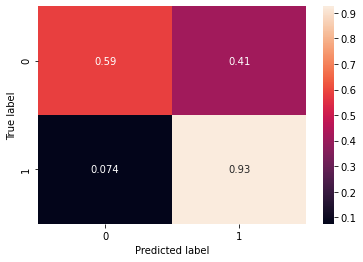

In [29]:
confusion = confusion_matrix(y_train_last2, predictions)
confusion_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
sns.heatmap(confusion_normalized,annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [470]:
accuracy_score(y_train_last2,preds)

0.837

In [512]:
pred_proba = model.predict_proba(X_test_last)

In [513]:
probs2 = pd.DataFrame(pred_proba)
probs2

,0,1
0,0.085994,0.914006
1,0.080374,0.919626
2,0.097447,0.902553
3,0.085994,0.914006
4,0.085994,0.914006
...,...,...
2375,0.372082,0.627918
2376,0.557422,0.442578
2377,0.469919,0.530081
2378,0.399007,0.600993


In [514]:
probs2.to_excel("probs_son.xlsx")

In [41]:
pred_proba

array([[0.00714286, 0.99285714],
       [0.00142857, 0.99857143],
       [0.03714286, 0.96285714],
       ...,
       [0.27285714, 0.72714286],
       [0.38142857, 0.61857143],
       [0.30428571, 0.69571429]])

In [483]:
roc_auc_score(y_train_last2,predictions)

0.7972027972027972

In [484]:
balanced_accuracy_score(y_train_last2,predictions)

0.7972027972027973

## XGBOOST

In [20]:
learning_rate = [0.1,1]
max_depth = [5,10,20]
n_estimators = [50,100,200]
params = {
 'learning_rate': learning_rate,
 'max_depth': max_depth,
 'n_estimators' : n_estimators
 }
rf=xgb.XGBClassifier(min_child_weight=10, reg_alpha=50, gamma=0.01,random_state=42)
rf_grid = GridSearchCV(estimator = model, param_grid = params, cv = 5, verbose=2, scoring='accuracy',n_jobs = -1)
rf_grid.fit(X_train_last3, y_train_last3)
print(rf_grid.best_params_)

NameError: name 'model' is not defined

In [21]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=10, min_child_weight=10, reg_alpha=50, gamma=0.01)
model.fit(X_train_last3,y_train_last3)
predictions = model.predict(X_train_last2)
accuracy_score(y_train_last2,predictions)

C:\Users\mertg\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:12:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.851

In [22]:
preds = np.where(model.predict_proba(X_train_last2)[:,1] > 0.6, 1, 0)

In [ ]:
model.predict_proba()

In [23]:
accuracy_score(y_train_last2,preds)

0.84

In [24]:
roc_auc_score(y_train_last2,preds)
balanced_accuracy_score(y_train_last2,preds)

0.8093240093240093

## SVM

In [451]:
C = [0.000001,0.00001,0.001,0.01,0.1,1]
degree = [1,2,3]
params = {
 'C': C,'degree': degree,
}
SVCmdl=SVC(random_state=42)
rf_grid = GridSearchCV(estimator = SVCmdl, param_grid = params, cv = 5, verbose=2, scoring='accuracy',n_jobs = -1)
rf_grid.fit(X_train_last3, y_train_last3)
print(rf_grid.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'C': 1e-06, 'degree': 1}


In [452]:
model = SVC(C=0.00001,degree=1)
model.fit(X_train_last3, y_train_last3)
predictions = model.predict(X_train_last2)
accuracy_score(y_train_last2,predictions)

0.6551928783382789

In [122]:
roc_auc_score(y_train_last2,predictions)
balanced_accuracy_score(y_train_last2,predictions)

0.5